## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

## Let's input all the features of the Iris Data Set

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [28]:
iris = pd.read_csv("Iris/iris.data",header=None,names=["f0","f1","f2","f3","class"])
iris.head()

,f0,f1,f2,f3,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [32]:
setosa = iris[iris["class"] == "Iris-setosa"]
setosa.loc[:,"class"] = -1
setosa.loc[:,"color"] = "DarkGreen"
setosa.head()

,f0,f1,f2,f3,class,color
0,5.1,3.5,1.4,0.2,-1,DarkGreen
1,4.9,3.0,1.4,0.2,-1,DarkGreen
2,4.7,3.2,1.3,0.2,-1,DarkGreen
3,4.6,3.1,1.5,0.2,-1,DarkGreen
4,5.0,3.6,1.4,0.2,-1,DarkGreen


In [33]:
versicolor = iris[iris["class"] == "Iris-versicolor"]
versicolor.loc[:,"class"] = 1
versicolor.loc[:,"color"] = "DarkBlue"
versicolor.head()

,f0,f1,f2,f3,class,color
50,7.0,3.2,4.7,1.4,1,DarkBlue
51,6.4,3.2,4.5,1.5,1,DarkBlue
52,6.9,3.1,4.9,1.5,1,DarkBlue
53,5.5,2.3,4.0,1.3,1,DarkBlue
54,6.5,2.8,4.6,1.5,1,DarkBlue


In [34]:
data = pd.concat([setosa,versicolor])

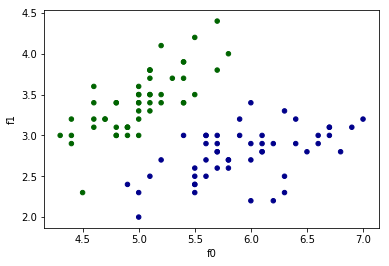

In [35]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [36]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,100.000000,100.000000,100.000000,100.000000
mean,5.471000,3.094000,2.862000,0.785000
std,0.641698,0.476057,1.448565,0.566288
min,4.300000,2.000000,1.000000,0.100000
25%,5.000000,2.800000,1.500000,0.200000
50%,5.400000,3.050000,2.450000,0.800000
75%,5.900000,3.400000,4.325000,1.300000
max,7.000000,4.400000,5.100000,1.800000


In [37]:
# data.mean()
# data["f0"] -= data.mean()[0]
# data["f1"] -= data.mean()[1]

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.loc[:,["f0","f1","f2","f3"]] = scaler.fit_transform(data.loc[:,["f0","f1","f2","f3"]])

In [39]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-1.547096e-15,2.176037e-16,-3.019807e-16,4.818368e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-1.834038e+00,-2.309621e+00,-1.291886e+00,-1.215726e+00
25%,-7.376874e-01,-6.206843e-01,-9.449779e-01,-1.038248e+00
50%,-1.112013e-01,-9.289152e-02,-2.858523e-01,2.662174e-02
75%,6.719064e-01,6.460183e-01,1.015053e+00,9.140132e-01
max,2.394743e+00,2.757189e+00,1.552761e+00,1.801405e+00


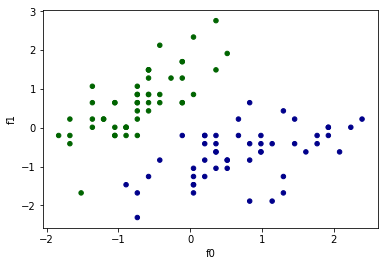

In [42]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [43]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [51]:
for i in range(len(data.index)):
    v = [data["f0"][i],data["f1"][i],data["f2"][i],data["f3"][i]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"], data.loc[i,"f2"], data.loc[i,"f3"] = v[0], v[1], v[2], v[3]

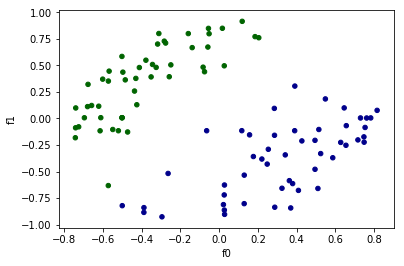

In [55]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [171]:
vectors = data.loc[[33,85,28,36],["f0","f1","f2","f3","class"]]
vectors["label"] = ["t0","t1","x0","x1"]
vectors

,f0,f1,f2,f3,class,label
33,0.016518,0.849161,-0.368896,-0.377583,-1,t0
85,0.391112,0.304957,0.536479,0.682805,1,t1
28,-0.258100,0.392836,-0.616820,-0.631346,-1,x0
36,0.026271,0.495761,-0.626828,-0.600515,-1,x1


In [138]:
vectors.iloc[:,0:4].apply(np.arcsin)

,f0,f1,f2,f3
33,0.016519,1.014394,-0.377820,-0.387185
85,0.401840,0.309893,0.566259,0.751596
28,-0.261055,0.403713,-0.664696,-0.683288
36,0.026274,0.518711,-0.677475,-0.644145


In [191]:
t0 = vectors.iloc[0:1,0:4].apply(np.arcsin).to_numpy()[0]

In [192]:
t1 = vectors.iloc[1:2,0:4].apply(np.arcsin).to_numpy()[0]

In [193]:
x0 = vectors.iloc[2:3,0:4].apply(np.arcsin).to_numpy()[0]

In [194]:
x1 = vectors.iloc[3:4,0:4].apply(np.arcsin).to_numpy()[0]

# Building the quantum circuit

To store 4 features I need 2 $i$ qubits.  
I need some ancilla qubits for the QRAM routine.  
I need one more bit to store the conditional measurement on the rotation qubit. 

In [195]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
import qiskit.aqua.circuits.gates.controlled_ry_gates

In [196]:
a = QuantumRegister(1,'a')
m = QuantumRegister(1,'m')
i = QuantumRegister(2,'i')
r = QuantumRegister(1,'r')
q = QuantumRegister(3,'q')
c = QuantumRegister(1,'c')
b = ClassicalRegister(3, 'bit')
circuit = QuantumCircuit(a,m,i,r,q,c,b)

circuit.h(a)
circuit.h(m)
circuit.h(i)
circuit.h(c)

circuit.barrier()

# circuit.cry(theta, control, target)
# circuit.mcry(theta, controls, target, ancillae)

# >>> Encode the input vector >>>

# |00>
circuit.x(i)
circuit.mcry(x0[0],a[:]+i[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(x0[1],a[:]+i[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(x0[2],a[:]+i[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(x0[3],a[:]+i[:],r[0],q)

circuit.x(a)

# <<< Encode the input vector <<<

circuit.barrier()

# >>> Encode the first training vector >>>

circuit.x(c)
circuit.x(m)

# |00>
circuit.x(i)
circuit.mcry(t0[0],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(t0[1],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(t0[2],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(t0[3],a[:]+i[:]+m[:]+c[:],r[0],q)

circuit.x(c)
circuit.x(m)

# <<< Encode the first training vector <<<

circuit.barrier()

# >>> Encode the second training vector >>>

# |00>
circuit.x(i)
circuit.mcry(t1[0],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i)

# |01>
circuit.x(i[1])
circuit.mcry(t1[1],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[1])

# |10>
circuit.x(i[0])
circuit.mcry(t1[2],a[:]+i[:]+m[:]+c[:],r[0],q)
circuit.x(i[0])

# |11>
circuit.mcry(t1[3],a[:]+i[:]+m[:]+c[:],r[0],q)

# <<< Encode the second training vector <<<

circuit.barrier()

# circuit.ccx(a,m,i)
# circuit.x(m)

# circuit.barrier()

# circuit.mcry(t1,a[:]+m[:],i[0],None)

# circuit.barrier()

# circuit.cx(m,c) Questo potrebbe essere una cosa che ho dimenticato

# circuit.barrier()

circuit.measure(r,b[0])

circuit.h(a)

circuit.measure(a,b[1])
circuit.measure(c,b[2])

# circuit.draw(output='mpl')


Total counts are: {'100': 3844, '111': 176, '001': 166, '010': 2, '101': 47, '110': 2, '000': 3904, '011': 51}


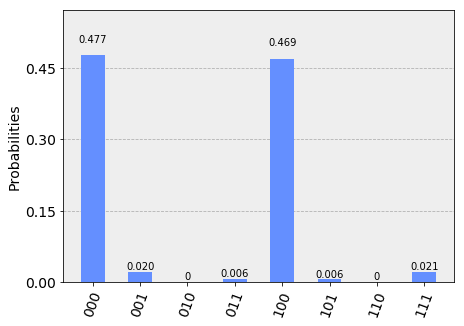

In [201]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

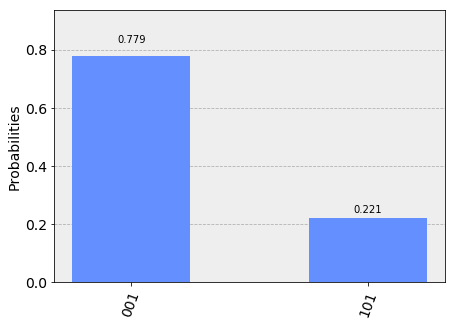

In [202]:
goodCounts = {k: counts[k] for k in counts.keys() & {'001', '101'}}
plot_histogram(goodCounts)